<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prophet" data-toc-modified-id="Prophet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prophet</a></span></li><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ARIMA</a></span></li><li><span><a href="#머신러닝" data-toc-modified-id="머신러닝-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>머신러닝</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Polynomial-Regression" data-toc-modified-id="Polynomial-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Polynomial Regression</a></span></li><li><span><a href="#PLS-Regression" data-toc-modified-id="PLS-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>PLS Regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li><li><span><a href="#XGBoost-Regressor" data-toc-modified-id="XGBoost-Regressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>XGBoost Regressor</a></span></li><li><span><a href="#LightGBM-Regressor" data-toc-modified-id="LightGBM-Regressor-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM Regressor</a></span></li><li><span><a href="#LightGBM(PCA로-차원축소)" data-toc-modified-id="LightGBM(PCA로-차원축소)-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>LightGBM(PCA로 차원축소)</a></span></li><li><span><a href="#Hybrid-Voting" data-toc-modified-id="Hybrid-Voting-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Hybrid Voting</a></span></li><li><span><a href="#RNN---LSTM" data-toc-modified-id="RNN---LSTM-3.9"><span class="toc-item-num">3.9&nbsp;&nbsp;</span>RNN - LSTM</a></span></li></ul></li></ul></div>

In [1]:
import pymysql
import numpy as np
import pandas as pd
import holidays
from itertools import chain
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings(action='ignore')


class WoochuriPredModel:
    '''
    Class including that crawl, preprocess data, modeling and finally prediction
    '''

    def __init__(self, user, password, end_time):
        self._user = user
        self._password = password
        self._end_time = end_time  # time that will be predicted

    def load_beef_pork(self):
        """
        Function: load beef and pork dataset. And preprocess it.
        """
        # connect local MySQL
        db = pymysql.connect(host='localhost', user=self._user,
                             password=self._password, db='beef_pork_db',
                             charset='utf8')
        cursor = db.cursor()
        # Select datasets using SQL
        beef_sql = "SELECT DISTINCT * FROM beef_prices WHERE 날짜 < '2011-03-03' AND 지역 = '전국'\
                            UNION\
                            SELECT DISTINCT * FROM beef_prices WHERE 날짜 >= '2011-03-03' AND 지역 = '중부권'\
                            ORDER BY 날짜"
        pork_sql = "SELECT DISTINCT * FROM pork_prices ORDER BY 날짜"

        beef_df = pd.read_sql(beef_sql, db)
        pork_df = pd.read_sql(pork_sql, db)

        # Preprocess beef dataset
        hanwoo_df = beef_df[beef_df['종류'] == '한우']
        yukwoo_df = beef_df[beef_df['종류'] == '육우']
        hanwoo_df = hanwoo_df.rename(columns={'종류': '한우', '가격': '한우가격'})
        yukwoo_df = yukwoo_df.rename(columns={'종류': '육우', '가격': '육우가격'})

        raw_date_df = pd.DataFrame(pd.date_range(start='2009-01-01', end=self._end_time, freq='D'))
        raw_date_df = raw_date_df.rename(columns={0: '날짜'})
        hanwoo_df = raw_date_df.merge(hanwoo_df, how='left')
        hanwoo_df = hanwoo_df[['날짜', '한우가격']]
        yukwoo_df = raw_date_df.merge(yukwoo_df, how='left')
        yukwoo_df = yukwoo_df[['날짜', '육우가격']]
        hanwoo_df = hanwoo_df.fillna(method='ffill')
        yukwoo_df = yukwoo_df.fillna(method='ffill')
        merge_beef_df = hanwoo_df.merge(yukwoo_df, how='inner', on='날짜')

        # Preprocess pork dataset
        cond_tang = pork_df['종류'] == '탕박'
        cond_n = pork_df['지역'] == '전국'
        pork_df = pork_df[(cond_tang) & (cond_n)]

        raw_date_df = pd.DataFrame(pd.date_range(start='2009-01-01', end=self._end_time, freq='D'))
        raw_date_df = raw_date_df.rename(columns={0: '날짜'})
        merge_pork_df = raw_date_df.merge(pork_df, how='left')
        merge_pork_df = merge_pork_df.fillna(method='ffill')
        merge_pork_df = merge_pork_df.rename(columns={'가격': '돼지탕박가격'})
        merge_cols = ['날짜', '돼지탕박가격']
        merge_pork_df = merge_pork_df[merge_cols]

        # Merge beef and pork dataset
        beef_pork_df = merge_beef_df.merge(merge_pork_df, how='inner', on='날짜')

        # Remove outlier (한우가격 < 육우가격)
        cond0 = beef_pork_df['한우가격'] < beef_pork_df['육우가격']
        cond1 = beef_pork_df['육우가격'] > 18000
        beef_pork_df.loc[(cond0 | cond1), '육우가격'] = beef_pork_df.loc[(cond0 | cond1)]['한우가격'] * (10 / 18)

        cond2 = beef_pork_df['한우가격'] < 1e4
        beef_pork_df.loc[cond2, '한우가격'] = beef_pork_df.loc[cond2]['육우가격'] * (18 / 10)

        return beef_pork_df

    def load_weather(self):
        """
        Function: load weather dataset and preprocess it
        """
        # load weather dataset
        db = pymysql.connect(host='localhost', user=self._user,
                             password=self._password, db='weather_db',
                             charset='utf8')
        cursor = db.cursor()
        # Select datasets using SQL
        weather_sql = "SELECT DISTINCT 지역, 시간,\
                                      NULLIF(평균기온, '') AS 평균기온,\
                                      NULLIF(최저기온, '') AS 최저기온,\
                                      NULLIF(최고기온, '') AS 최고기온,\
                                      NULLIF(1시간최다강수량, '') AS 1시간최다강수량,\
                                      NULLIF(일강수량, '') AS 일강수량,\
                                      NULLIF(평균풍속, '') AS 평균풍속,\
                                      NULLIF(최대풍속, '') AS 최대풍속,\
                                      NULLIF(평균상대습도, '') AS 평균상대습도,\
                                      NULLIF(최소상대습도, '') AS 최소상대습도,\
                                      NULLIF(1시간최다일사량, '') AS 1시간최다일사량,\
                                      NULLIF(일사량, '') AS 일사량\
                                      FROM weather\
                                      ORDER BY 시간"
        weather = pd.read_sql(weather_sql, db)
        weather = weather.rename(columns={'시간': '날짜'})

        # Replace missing values in weather dataset
        dataset = weather.copy()
        dataset = dataset.drop(['1시간최다강수량'], axis=1)
        dataset['일강수량'] = dataset['일강수량'].fillna(0.0)

        avg_wind = dataset[['평균풍속', '최대풍속']]  # 결측치:평균풍속
        avg_humid = dataset[['평균상대습도', '최소상대습도', '최저기온', '일강수량', '평균기온', '최고기온']]  # 결측치:평균상대습도
        max_sun_h = dataset[['1시간최다일사량', '최고기온', '평균기온', '최저기온', '최소상대습도']]  # 결측치:1시간최다일사량
        max_sun = dataset[['일사량', '최고기온', '평균기온', '최저기온', '최소상대습도']]  # 결측치:일사량

        knn_datasets = [avg_wind, avg_humid, max_sun_h, max_sun]
        after_datasets = []
        for data in knn_datasets:
            imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
            imputer.fit(data.values)
            after_values = imputer.transform(data.values)  # array
            after_dataset = pd.DataFrame(after_values, columns=data.columns)
            after_datasets.append(after_dataset)
        concat_df = pd.concat([after_datasets[0], after_datasets[1], after_datasets[2], after_datasets[3]], axis=1)
        concat_cols = concat_df.columns.tolist()
        transform_dict = {}

        for i, v in enumerate(concat_df.values.T):
            transform_dict[concat_cols[i]] = v
        transform_df = pd.DataFrame(transform_dict)

        standard_cols = set(dataset.columns) - set(transform_df.columns)
        dataset = pd.concat([dataset[standard_cols], transform_df], axis=1)

        weather = dataset.copy()
        weather = weather.drop('지역', axis=1)

        return weather

    def load_woochuri(self):
        """
        Function: load Woochuri daily sales and preprocess it
        """
        db = pymysql.connect(host='localhost', user=self._user,
                             password=self._password, db='sales_db',
                             charset='utf8')
        cursor = db.cursor()

        sales_sql = "SELECT DISTINCT * FROM sales ORDER BY 날짜"
        sales = pd.read_sql(sales_sql, db)

        present_time = int(pd.Timestamp.now().strftime("%Y"))
        kor_holidays = holidays.Korea(years=[d for d in range(2008, present_time + 1)])

        holidays_dates = []
        holidays_names = []
        for date, name in kor_holidays.items():
            holidays_dates.append(date)
            holidays_names.append(name)

        holidays_df = pd.DataFrame({'공휴일날짜': holidays_dates,
                                    '공휴일명': holidays_names}).sort_values(by='공휴일날짜')
        holidays_df['공휴일날짜'] = pd.to_datetime(holidays_df['공휴일날짜'])

        next_five_time = pd.date_range(start=self._end_time, freq='D', periods=6)[-1].strftime('%Y-%m-%d')
        extra_datetime = pd.DataFrame(pd.date_range(start='2009-01-01', end=next_five_time, freq='D'),
                                      columns=['가중치위한날짜'])
        sales = extra_datetime.merge(sales, how='left', left_on='가중치위한날짜', right_on='날짜')
        sales = sales.drop('날짜', axis=1)
        sales = sales.rename(columns={'가중치위한날짜': '날짜'})
        sales_holiday_df = sales.merge(holidays_df, how='left', left_on='날짜', right_on='공휴일날짜')

        hol_cols = ['날짜', '일매출', 'remark', '공휴일날짜', '공휴일명']
        holidays_data = sales_holiday_df[hol_cols]
        holidays_data['요일'] = holidays_data['날짜'].dt.day_name()
        hol_cols = ['날짜', '요일', '일매출', 'remark', '공휴일날짜', '공휴일명']
        holidays_data = holidays_data[hol_cols]

        lunar_chuseok = ["The day preceding of Lunar New Year's Day", "The day preceding of Chuseok"]
        lunar_chuseok_dates = holidays_data[holidays_data['공휴일명'].isin(lunar_chuseok)]['날짜'].dt.strftime(
            '%Y-%m-%d').values
        lunar_chuseok_around_dates = []
        for date in lunar_chuseok_dates:
            around = pd.date_range(end=date, freq='D', periods=6)
            lunar_chuseok_around_dates.append(around)
        lunar_chuseok_arounds = list(chain.from_iterable(lunar_chuseok_around_dates))

        lunar_chuseok_dict = {}
        weight = 0
        for around_date in lunar_chuseok_arounds:
            weight += 1
            if weight > 6:
                weight = 1
            lunar_chuseok_dict[around_date] = weight

        def holidays_weights(df):
            df['설_추석_가중치'] = 0
            df['일반공휴일가중치'] = 0
            if df['날짜'] in list(lunar_chuseok_dict.keys()):
                df['설_추석_가중치'] = lunar_chuseok_dict[df['날짜']]
            return df

        holidays_data = holidays_data.apply(holidays_weights, axis=1)
        holidays_data.loc[(~holidays_data['공휴일명'].str.contains('Lunar|Chuseok', na=False)) & (
            holidays_data['공휴일명'].notnull()), '일반공휴일가중치'] = 1

        need_cols = ['날짜', '요일', '일매출', '설_추석_가중치', '일반공휴일가중치']
        holidays_data = holidays_data[need_cols]

        return holidays_data

    def merge_datasets(self, beef_pork, weather, sales):
        """
        Function: Merge all datasets
        Args:
            - beef_pork: 예측하려는 날 이전 데이터까지 존재
            - weather: 예측하려는 날 이전 데이터까지 존재
            - sales: 예측하려는 날로부터 미래 5일까지의 데이터가 존재
        """
        # Check each shape of dataframes
        print('Beef & Pork:', beef_pork.shape)
        print(beef_pork.tail())
        print('-'*50)
        print('Weather:', weather.shape)
        print(weather.tail())
        print('-' * 50)
        print('Woochuri Sales:', sales.shape)
        print(sales.tail())
        print('-' * 50)

        # Merge all datasets
        beef_pork_weather = beef_pork.merge(weather, how='inner', on='날짜')
        dataset = sales.merge(beef_pork_weather, how='left', on='날짜')
        dataset = dataset.iloc[:-5]  # remove more five rows
        print("Final dataset:", dataset.shape)

        # Preprocess zero-sales
        days = dataset.groupby('요일')['일매출'].mean().index
        means = dataset.groupby('요일')['일매출'].mean().values
        weekdays_means = dict(zip(days, means))

        def replace_zero_sales(df):
            if df['일매출'] == 0:
                df['일매출'] = weekdays_means[df['요일']]
            return df

        dataset = dataset.apply(replace_zero_sales, axis=1)

        # Give weights to weekday
        weekdays = dataset.groupby('요일')['일매출'].mean().index
        values = dataset.groupby('요일')['일매출'].mean().values
        weekdays_dict = dict(zip(weekdays, values))
        dataset['요일'] = dataset['요일'].map(weekdays_dict)

        # Give weights to day(1day~31day)
        dataset['일'] = dataset['날짜'].dt.day
        daily = dataset.groupby('일')['일매출'].mean().index
        values = dataset.groupby('일')['일매출'].mean().values
        daily_dict = dict(zip(daily, values))
        dataset['일'] = dataset['일'].map(daily_dict)

        # remove multi-Colinearity
        multi_cols = ['최소상대습도', '최저기온', '평균기온', '1시간최다일사량']
        final_dataset = dataset.drop(multi_cols, axis=1)
        final_dataset = final_dataset.set_index('날짜')

        return final_dataset

    def execute(self):
        """
        Function: After loading, preprocessing each dataset, merge all datasets into final dataset
        """
        BeefPork = self.load_beef_pork()
        Weather = self.load_weather()
        Sales = self.load_woochuri()
        FinalDataset = self.merge_datasets(BeefPork, Weather, Sales)

        return FinalDataset

    def run(self, final_dataset):
        """
        Function: modeling and predict tomorrow sales of 'Woochuri Store'
        """
        # Make target variable
        final_dataset['target'] = np.append(np.array(final_dataset['일매출'][1:]), 0)

        # Split train and test data
        X_train, y_train = final_dataset.iloc[:-1, :-1], final_dataset.iloc[:-1, -1]
        X_test = final_dataset.iloc[-1, :-1]
        X_test = pd.DataFrame(X_test.values.reshape(1, -1),
                              columns=X_test.index)  # Create one-row dataframe

        # Apply MinMaxScaler partly
        scaler = MinMaxScaler()
        no_scale_cols = ['설_추석_가중치', '일반공휴일가중치']
        scale_cols = ['일매출', '요일', '일', '한우가격', '육우가격', '돼지탕박가격', '평균상대습도', '최고기온', '평균풍속', '최대풍속',
                      '일사량', '일강수량']

        X_train_scale = X_train[scale_cols]
        X_train_no_scale = X_train[no_scale_cols]
        X_test_scale = X_test[scale_cols]
        X_test_no_scale = X_test[no_scale_cols]

        X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_scale),
                                     columns=X_train_scale.columns,
                                     index=X_train_scale.index)
        X_test_scale = pd.DataFrame(scaler.transform(X_test_scale),
                                    columns=X_test_scale.columns,
                                    index=X_test_scale.index)

        X_train = pd.concat([X_train_scale, X_train_no_scale], axis=1)
        X_test = pd.concat([X_test_scale, X_test_no_scale], axis=1)

        # fit model
        model = RandomForestRegressor(n_estimators=100,
                                      min_samples_split=2,
                                      random_state=42)
        model.fit(X_train, y_train)

        # Predict sale of next day
        y_pred = model.predict(X_test)
        res = int(y_pred[0]) / 1e4
        # print result
        weekday_map = {'Sunday': '일요일', 'Monday': '월요일',
                       'Tuesday': '화요일', 'Wednesday': '수요일',
                       'Thursday': '목요일', 'Friday': '금요일',
                       'Saturday': '토요일'}

        pred_time = pd.Timestamp.now()
        day_name = pred_time.day_name()
        str_pred_time = pred_time.strftime("%Y-%m-%d")
        result = f"[우추리 축산 AI] - {str_pred_time}일 {weekday_map[day_name]} 우추리축산 매출은{res: .0f}만원 입니다."
        print(result)

        return result

In [2]:
end_time = (pd.Timestamp.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
woochuri = WoochuriPredModel(user='root', password='watson1259@', end_time=end_time)
dataset = woochuri.execute()
dataset.shape

Beef & Pork: (4507, 4)
             날짜     한우가격     육우가격  돼지탕박가격
4502 2021-04-30  21843.0  11472.0  5257.0
4503 2021-05-01  21843.0  11472.0  5257.0
4504 2021-05-02  21843.0  11472.0  5257.0
4505 2021-05-03  16455.0   4754.0  5551.0
4506 2021-05-04  21523.0  11329.0  5331.0
--------------------------------------------------
Weather: (4507, 11)
             날짜  평균풍속  최대풍속  평균상대습도  최소상대습도  최저기온  일강수량  평균기온  최고기온  1시간최다일사량  \
4502 2021-04-30   2.4  11.6    70.9    44.0  10.5   0.6  13.1  17.6     3.320   
4503 2021-05-01   1.7   4.0    79.3    55.0   9.4   1.4  10.5  13.3     1.260   
4504 2021-05-02   1.6   3.2    69.0    36.0   7.9   2.6  13.0  19.6     2.604   
4505 2021-05-03   1.5   3.8    56.4    21.0   6.6   0.0  15.1  23.3     3.490   
4506 2021-05-04   1.4   6.3    76.6    54.0  11.8   5.2  17.2  23.0     1.220   

         일사량  
4502  16.690  
4503   7.480  
4504  16.982  
4505  26.950  
4506   8.680  
--------------------------------------------------
Woochuri Sales: (4512, 5)


(4507, 14)

# Prophet

In [5]:
df = dataset[['일매출']]
df = df.reset_index()
df.head()

,날짜,일매출
0,2009-01-01,625135.149068
1,2009-01-02,666950.000000
2,2009-01-03,854000.000000
3,2009-01-04,706000.000000
4,2009-01-05,451800.000000


In [21]:
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import time

fb_df = df
fb_df.columns = ['ds', 'y']
fb_df['ds'] = pd.to_datetime(fb_df['ds'])
TRAIN_SPLIT = len(fb_df) - (365+1)

start = time.time()

TRAIN_MAPE = []
TEST_MAPE = []

for i in range(0, (len(fb_df)-(1+TRAIN_SPLIT))):
    if i % 10 == 0:
        print(f"{i}번째 교차검증 시작")
    train = fb_df.iloc[:TRAIN_SPLIT+i]
    test = fb_df.iloc[TRAIN_SPLIT+i+1]
    test = pd.DataFrame(test.values.reshape(1, -1),
                       columns=train.columns)
    # fit
    model = Prophet()
    model.fit(train)
    
    # Predict train and test
    train_forecast = model.predict(train[['ds']])
    test_forecast = model.predict(test[['ds']])
    
    # Evaluate MAPE
    train_pred = train_forecast['yhat'].values
    test_pred = test_forecast['yhat'].values
    
    train_y = train['y'].values
    test_y = test['y'].values
    
    train_mape = mean_absolute_percentage_error(train_y, train_pred)
    test_mape = mean_absolute_percentage_error(test_y, test_pred)
#     print('train mape:', train_mape)
#     print('test mape:', test_mape)
    
    TRAIN_MAPE.append(train_mape)
    TEST_MAPE.append(test_mape)

print("총 학습시간:", round(time.time() - start, 3))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

10번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

20번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

30번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

40번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

50번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

60번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

70번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

80번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

90번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

100번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

110번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

120번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

130번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

140번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

150번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

160번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

170번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

180번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

190번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

200번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

210번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

220번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

230번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

240번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

250번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

260번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

270번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

280번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

290번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

300번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

310번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

320번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

330번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

340번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

350번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

360번째 교차검증 시작


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


총 학습시간: 1437.8


In [31]:
print(f"Train MAPE: {sum(TRAIN_MAPE)/len(TRAIN_MAPE) * 100: .2f}%")
print(f"Test MAPE: {sum(TEST_MAPE)/len(TEST_MAPE) * 100: .2f}%")

Train MAPE:  51.80%
Test MAPE:  41.75%


# ARIMA

In [ ]:
from pmdarima.arima import ARIMA

cross_df = df[['y']]
TRAIN_SPLIT = len(cross_df) - (365+1)
TRAIN_MAPE = []
TEST_MAPE = []

start = time.time()

for i in range(0, (len(cross_df)-(1+TRAIN_SPLIT))):
    if i % 10 == 0:
        print(f"{i}번째 교차검증 수행")
    train = cross_df.iloc[:TRAIN_SPLIT+i]
    test = cross_df.iloc[TRAIN_SPLIT+i+1]
    test = pd.DataFrame(test.values.reshape(1, -1),
                       columns=train.columns)
    # fit & Predict train
    model = ARIMA(order=(1, 0, 1),
                 seasonal_order=(1, 0, 1, 7))
    train_pred = model.fit_predict(train, n_periods=train.shape[0]) # Train에 대한 예측값(periods 값이 교차검증할 때마다 달라지므로!)
    # Predict test
    test_pred = model.predict(n_periods=1)
    # Evaluate
    train_y = train.values.reshape(-1,)
    test_y = test.values.reshape(-1,)
    
    train_mape = mean_absolute_percentage_error(train_y, train_pred)
    test_mape = mean_absolute_percentage_error(test_y, test_pred)
    #print(train_mape, test_mape)
    TRAIN_MAPE.append(train_mape)
    TEST_MAPE.append(test_mape)
    
print("총 수행시간:", round(time.time() - start))

print(f"Train MAPE: {sum(TRAIN_MAPE)/len(TRAIN_MAPE) * 100: .2f}%")
print(f"Test MAPE: {sum(TEST_MAPE)/len(TEST_MAPE) * 100: .2f}%")

# 머신러닝

In [120]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def evaluate_cv_predict(dataset, regressor):
    start = time.time()
    
    TRAIN_MAPE = []
    TEST_MAPE = []
    TEST_TARGET = []
    TEST_PRED = []
    
    TRAIN_SPLIT = len(dataset) - 365
    for i in range(0, len(dataset)-(TRAIN_SPLIT)):
        if (i+1) % 10 == 0 or (i+1) == 365:
            print(f"# {i+1}번째 교차검증 수행")
        # Make target
        dataset['target'] = np.append(np.array(dataset['일매출'][1:]), 0)
        train = dataset.iloc[:i+TRAIN_SPLIT-1]
        test = dataset.iloc[i+TRAIN_SPLIT-1]
        # memorize TEST_TARGET
        TEST_TARGET.append(test.values[-1])
        test = pd.DataFrame(data=test.values.reshape(1, -1),
                           columns=test.index)
        
        # Split TRAIN and TEST
        X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
        X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

        # Scaling
        scaler = MinMaxScaler()
        no_scale_cols = ['요일', '설_추석_가중치', '일반공휴일가중치']
        scale_cols = ['일매출', '한우가격', '육우가격', '돼지탕박가격', '평균상대습도', '최고기온', '평균풍속', '최대풍속',
                      '일사량', '일강수량']

        X_train_scale = X_train[scale_cols]
        X_train_no_scale = X_train[no_scale_cols]
        X_test_scale = X_test[scale_cols]
        X_test_no_scale = X_test[no_scale_cols]

        X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_scale),
                                     columns=X_train_scale.columns,
                                     index=X_train_scale.index)
        X_test_scale = pd.DataFrame(scaler.transform(X_test_scale),
                                    columns=X_test_scale.columns,
                                    index=X_test_scale.index)

        X_train = pd.concat([X_train_scale, X_train_no_scale], axis=1)
        X_test = pd.concat([X_test_scale, X_test_no_scale], axis=1)
        
        # fit model
        model = regressor
        model.fit(X_train, y_train)
        # Prediction
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        # memorize TEST_PRED
        TEST_PRED.append(test_pred[0])
        
        # Evaluate
        train_mape = mean_absolute_percentage_error(y_train, train_pred)
        test_mape = mean_absolute_percentage_error(y_test, test_pred)
        TRAIN_MAPE.append(train_mape)
        TEST_MAPE.append(test_mape)
    
    # mean MAPE over all CV
    MEAN_TRAIN_MAPE = np.array(TRAIN_MAPE).mean()
    MEAN_TEST_MAPE = np.array(TEST_MAPE).mean()
    # make dataframe including 'test_y_true', 'test_y_pred'
    TEST_DF = pd.DataFrame({'y_true': TEST_TARGET,
                           'y_pred': TEST_PRED})
    print('-'*50)
    print(f"# Train MAPE:{MEAN_TRAIN_MAPE*100: .2f}%")
    print(f"# Test MAPE:{MEAN_TEST_MAPE*100: .2f}%")
    
    # visualize two line graph(target, prediction)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=TEST_DF)
    plt.title("실제값과 예측값 비교 Line Graph", fontsize=18)
    plt.xlabel("날짜", fontsize=17)
    plt.ylabel("일 매출", fontsize=17)
    plt.legend(['Target', 'Predicted'])
    plt.show()
    
    return TEST_DF  

## Linear Regression

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 43.51%
# Test MAPE: 52.20%


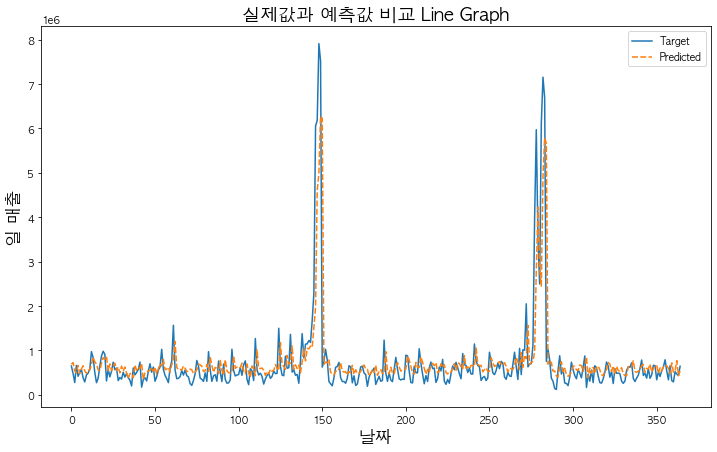

In [124]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()

test_df = evaluate_cv_predict(dataset=dataset,
                             regressor=lr_reg)

## Polynomial Regression

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 41.02%
# Test MAPE: 49.41%


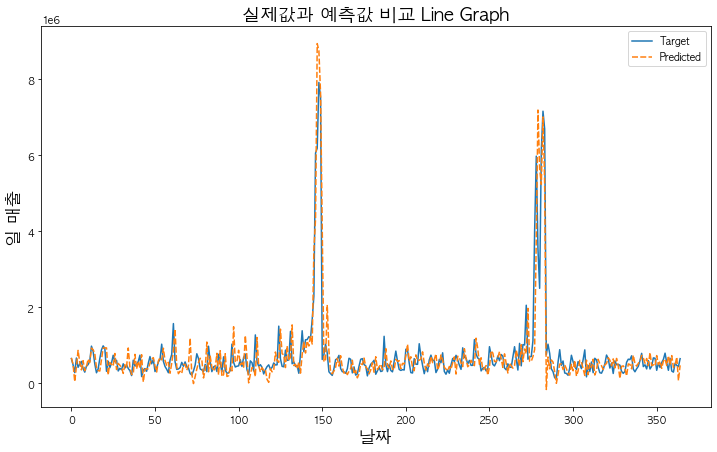

In [110]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 1차적인 모델링 수행했을 때 2차항이 가장 최적이었으므로 2차항으로 설정
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=2,
                                                include_bias=True)),
                    ('linear', LinearRegression())])

test_df = evaluate_cv_predict(dataset=dataset,
                              regressor=poly_reg)

## PLS Regression

- ``부분 최소제곱 회귀``
- Supervised Feature Reduction Regression

In [121]:
# PLS Regression에서 test_pred 저장할 때 2차원 array로 반환되어서 인덱스 한 번 더 붙여준것 빼고는 나머지 로직 동일한 함수
def pls_cv_predict(dataset, regressor):
    start = time.time()
    
    TRAIN_MAPE = []
    TEST_MAPE = []
    TEST_TARGET = []
    TEST_PRED = []
    
    TRAIN_SPLIT = len(dataset) - 365
    for i in range(0, len(dataset)-(TRAIN_SPLIT)):
        if (i+1) % 10 == 0 or (i+1) == 365:
            print(f"# {i+1}번째 교차검증 수행")
        # Make target
        dataset['target'] = np.append(np.array(dataset['일매출'][1:]), 0)
        train = dataset.iloc[:i+TRAIN_SPLIT-1]
        test = dataset.iloc[i+TRAIN_SPLIT-1]
        # memorize TEST_TARGET
        TEST_TARGET.append(test.values[-1])
        test = pd.DataFrame(data=test.values.reshape(1, -1),
                           columns=test.index)
        
        # Split TRAIN and TEST
        X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
        X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

        # Scaling
        scaler = MinMaxScaler()
        no_scale_cols = ['요일', '설_추석_가중치', '일반공휴일가중치']
        scale_cols = ['일매출', '한우가격', '육우가격', '돼지탕박가격', '평균상대습도', '최고기온', '평균풍속', '최대풍속',
                      '일사량', '일강수량']

        X_train_scale = X_train[scale_cols]
        X_train_no_scale = X_train[no_scale_cols]
        X_test_scale = X_test[scale_cols]
        X_test_no_scale = X_test[no_scale_cols]

        X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_scale),
                                     columns=X_train_scale.columns,
                                     index=X_train_scale.index)
        X_test_scale = pd.DataFrame(scaler.transform(X_test_scale),
                                    columns=X_test_scale.columns,
                                    index=X_test_scale.index)

        X_train = pd.concat([X_train_scale, X_train_no_scale], axis=1)
        X_test = pd.concat([X_test_scale, X_test_no_scale], axis=1)
        
        # fit model
        model = regressor
        model.fit(X_train, y_train)
        # Prediction
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        # memorize TEST_PRED
        TEST_PRED.append(test_pred[0][0])
        
        # Evaluate
        train_mape = mean_absolute_percentage_error(y_train, train_pred)
        test_mape = mean_absolute_percentage_error(y_test, test_pred)
        TRAIN_MAPE.append(train_mape)
        TEST_MAPE.append(test_mape)
    
    # mean MAPE over all CV
    MEAN_TRAIN_MAPE = np.array(TRAIN_MAPE).mean()
    MEAN_TEST_MAPE = np.array(TEST_MAPE).mean()
    # make dataframe including 'test_y_true', 'test_y_pred'
    TEST_DF = pd.DataFrame({'y_true': TEST_TARGET,
                           'y_pred': TEST_PRED})
    print('-'*50)
    print(f"# Train MAPE:{MEAN_TRAIN_MAPE*100: .2f}%")
    print(f"# Test MAPE:{MEAN_TEST_MAPE*100: .2f}%")
    
    # visualize two line graph(target, prediction)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=TEST_DF)
    plt.title("실제값과 예측값 비교 Line Graph", fontsize=18)
    plt.xlabel("날짜", fontsize=17)
    plt.ylabel("일 매출", fontsize=17)
    plt.legend(['Target', 'Predicted'])
    plt.show()
    
    return TEST_DF  

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 44.68%
# Test MAPE: 62.21%


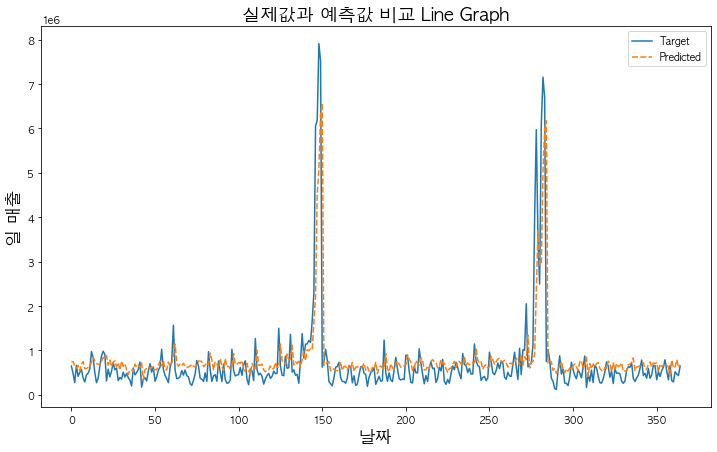

In [122]:
from sklearn.cross_decomposition import PLSRegression

pls_reg = PLSRegression(n_components=3)

test_df = pls_cv_predict(dataset=dataset,
                         regressor=pls_reg)

## Random Forest Regressor

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 11.10%
# Test MAPE: 34.32%


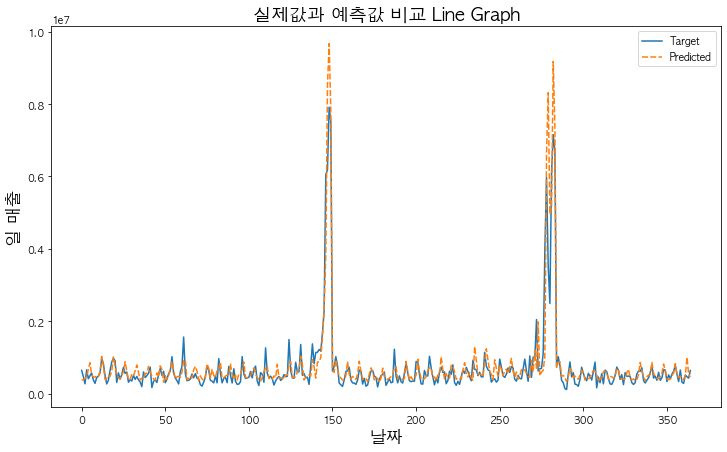

In [123]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

test_df = evaluate_cv_predict(dataset=dataset,
                              regressor=rf_reg)

## XGBoost Regressor

[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

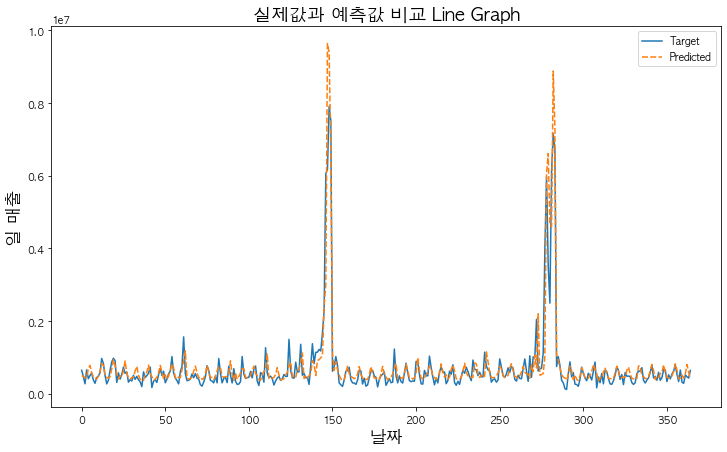

In [125]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()

test_df = evaluate_cv_predict(dataset=dataset,
                              regressor=xgb_reg)

## LightGBM Regressor

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 22.19%
# Test MAPE: 34.22%


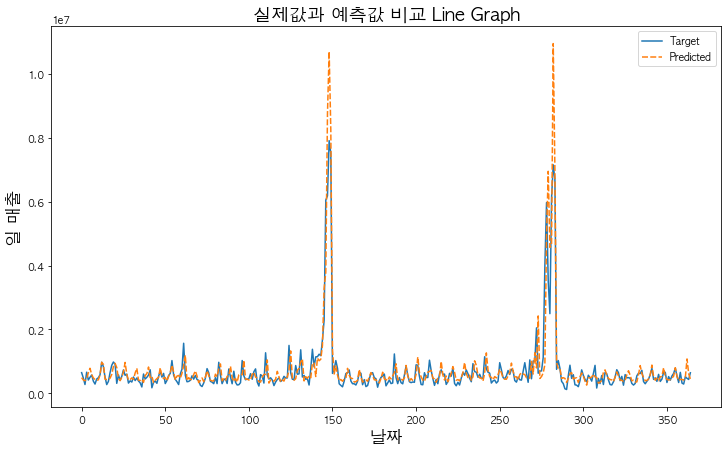

In [126]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor()

test_df = evaluate_cv_predict(dataset=dataset,
                              regressor=lgb_reg)

## LightGBM(PCA로 차원축소)

In [127]:
from sklearn.decomposition import PCA

def pca_cv_predict(dataset, regressor):
    start = time.time()
    
    TRAIN_MAPE = []
    TEST_MAPE = []
    TEST_TARGET = []
    TEST_PRED = []
    
    TRAIN_SPLIT = len(dataset) - 365
    for i in range(0, len(dataset)-(TRAIN_SPLIT)):
        if (i+1) % 10 == 0 or (i+1) == 365:
            print(f"# {i+1}번째 교차검증 수행")
        # Make target
        dataset['target'] = np.append(np.array(dataset['일매출'][1:]), 0)
        train = dataset.iloc[:i+TRAIN_SPLIT-1]
        test = dataset.iloc[i+TRAIN_SPLIT-1]
        # memorize TEST_TARGET
        TEST_TARGET.append(test.values[-1])
        test = pd.DataFrame(data=test.values.reshape(1, -1),
                           columns=test.index)
        
        # Split TRAIN and TEST
        X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
        X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

        # PCA
        pca = PCA(n_components=7)
        pca_cols = [f"PCA{p+1}" for p in range(0, 7)]
        X_train = pd.DataFrame(pca.fit_transform(X_train),
                              columns=pca_cols,
                              index=X_train.index)
        X_test = pd.DataFrame(pca.transform(X_test),
                             columns=pca_cols,
                             index=X_test.index)
        
        # fit model
        model = regressor
        model.fit(X_train, y_train)
        # Prediction
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        # memorize TEST_PRED
        TEST_PRED.append(test_pred[0])
        
        # Evaluate
        train_mape = mean_absolute_percentage_error(y_train, train_pred)
        test_mape = mean_absolute_percentage_error(y_test, test_pred)
        TRAIN_MAPE.append(train_mape)
        TEST_MAPE.append(test_mape)
    
    # mean MAPE over all CV
    MEAN_TRAIN_MAPE = np.array(TRAIN_MAPE).mean()
    MEAN_TEST_MAPE = np.array(TEST_MAPE).mean()
    # make dataframe including 'test_y_true', 'test_y_pred'
    TEST_DF = pd.DataFrame({'y_true': TEST_TARGET,
                           'y_pred': TEST_PRED})
    print('-'*50)
    print(f"# Train MAPE:{MEAN_TRAIN_MAPE*100: .2f}%")
    print(f"# Test MAPE:{MEAN_TEST_MAPE*100: .2f}%")
    
    # visualize two line graph(target, prediction)
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=TEST_DF)
    plt.title("실제값과 예측값 비교 Line Graph", fontsize=18)
    plt.xlabel("날짜", fontsize=17)
    plt.ylabel("일 매출", fontsize=17)
    plt.legend(['Target', 'Predicted'])
    plt.show()
    
    return TEST_DF  

# 10번째 교차검증 수행
# 20번째 교차검증 수행
# 30번째 교차검증 수행
# 40번째 교차검증 수행
# 50번째 교차검증 수행
# 60번째 교차검증 수행
# 70번째 교차검증 수행
# 80번째 교차검증 수행
# 90번째 교차검증 수행
# 100번째 교차검증 수행
# 110번째 교차검증 수행
# 120번째 교차검증 수행
# 130번째 교차검증 수행
# 140번째 교차검증 수행
# 150번째 교차검증 수행
# 160번째 교차검증 수행
# 170번째 교차검증 수행
# 180번째 교차검증 수행
# 190번째 교차검증 수행
# 200번째 교차검증 수행
# 210번째 교차검증 수행
# 220번째 교차검증 수행
# 230번째 교차검증 수행
# 240번째 교차검증 수행
# 250번째 교차검증 수행
# 260번째 교차검증 수행
# 270번째 교차검증 수행
# 280번째 교차검증 수행
# 290번째 교차검증 수행
# 300번째 교차검증 수행
# 310번째 교차검증 수행
# 320번째 교차검증 수행
# 330번째 교차검증 수행
# 340번째 교차검증 수행
# 350번째 교차검증 수행
# 360번째 교차검증 수행
# 365번째 교차검증 수행
--------------------------------------------------
# Train MAPE: 25.50%
# Test MAPE: 37.70%


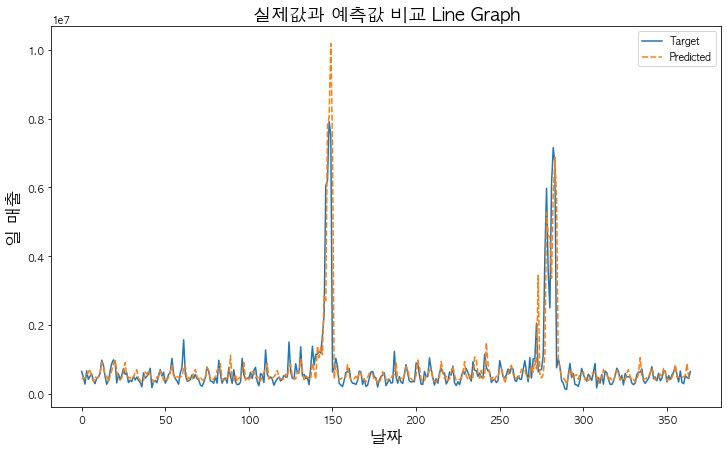

In [128]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor()

test_df = pca_cv_predict(dataset=dataset,
                         regressor=lgb_reg)

## Hybrid Voting

- ``Random Forest + XGBoost + LightGBM``

[19:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:42:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:45:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:48:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:52:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:52:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[19:59:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:00:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

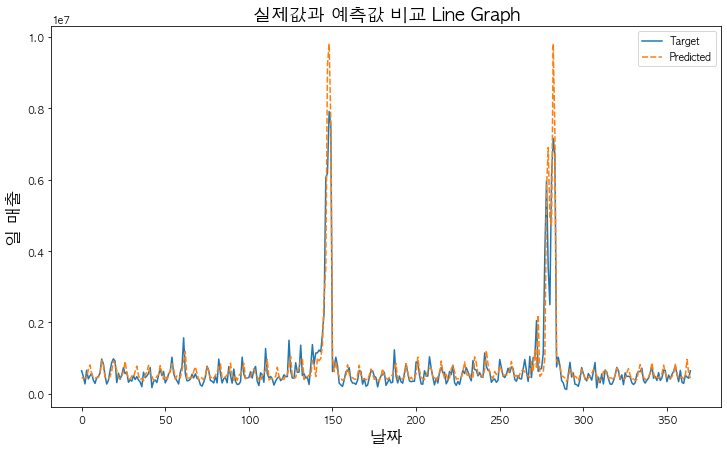

In [129]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

hb_vote = VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                                     ('xgb', XGBRegressor()),
                                     ('lgbm', LGBMRegressor())])

test_df = evaluate_cv_predict(dataset=dataset,
                              regressor=hb_vote)

## RNN - LSTM

In [4]:
import math
import tensorflow as tf

no_scale_cols = ['요일', '설_추석_가중치', '일반공휴일가중치', 'target']
scale_cols = ['일매출', '한우가격', '육우가격', '돼지탕박가격', '평균상대습도', '최고기온', '평균풍속', '최대풍속',
             '일사량', '일강수량']

DL_df = dataset.copy()
DL_df['target'] = np.append(np.array(DL_df.iloc[1:, 1]), 0)
DL_df = DL_df.iloc[:-1, :]

# Train, Test Scaling
TRAIN_SPLIT = math.floor(DL_df.shape[0] * 0.9)

no_scale_feature = DL_df[no_scale_cols].values
scale_feature = DL_df[scale_cols].values
# Scaling
scale_mean = scale_feature[:TRAIN_SPLIT].mean(axis=0)
scale_std = scale_feature[:TRAIN_SPLIT].std(axis=0)
scale_feature = (scale_feature - scale_mean)/scale_std

print('No scale shape:', no_scale_feature.shape)
print("scale shape:", scale_feature.shape)

No scale shape: (4506, 4)
scale shape: (4506, 10)


In [5]:
dataset = np.concatenate((no_scale_feature, scale_feature), axis=1)
print("Merge shape:", dataset.shape)

Merge shape: (4506, 14)


In [7]:
# Single step model
# history_size : 과거의 몇 개 데이터를 볼건지
# step : 몇 단계의 미래값을 예측할지(현재 문제에선 다음단계니까 step=1)
# target_size : 예측할 값의 size(현재 문제에선 다음날 하루예측이니까 1)

def multivariate_data(dataset, target, start_idx, end_idx,
                     history_size, target_size, step,
                     single_step=False):
    data = []
    labels = []
    start_idx = start_idx + history_size
    # 마지막 인덱스 지정하지 않으면 -> 그런데 내가 이미 마지막 데이터짤라놓았음..!
    if end_idx is None:
        end_idx = len(dataset) - target_size
    
    for i in range(start_idx, end_idx):
        # i-history_size ~ i-1까지 step 간격의 인덱스
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size-1]) 
    return np.asarray(data), np.asarray(labels)

In [8]:
target = DL_df.iloc[:,-1].values
past_history = 7
future_target = 1
step = 1

X_train, y_train = multivariate_data(dataset, target, 0,
                                    TRAIN_SPLIT, past_history,
                                    future_target, step,
                                    single_step=True)
X_test, y_test = multivariate_data(dataset, target, TRAIN_SPLIT,
                                  len(dataset), past_history,
                                  future_target, step,
                                  single_step=True)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4048, 7, 14) (4048,)
(444, 7, 14) (444,)


In [11]:
X_train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
X_test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                          padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train, y_train, epochs=30, verbose=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
4048/4048 [==============================] - 4s 946us/sample - loss: 729525.4392
Epoch 2/30
4048/4048 [==============================] - 2s 415us/sample - loss: 537235.7016
Epoch 3/30
4048/4048 [==============================] - 2s 429us/sample - loss: 333222.2979
Epoch 4/30
4048/4048 [==============================] - 2s 411us/sample - loss: 331572.9079
Epoch 5/30
4048/4048 [==============================] - 2s 443us/sample - loss: 325026.9972
Epoch 6/30
4048/4048 [==============================] - 2s 432us/sample - loss: 323569.6827
Epoch 7/30
4048/4048 [==============================] - 2s 428us/sample - loss: 313461.2826
Epoch 8/30
4048/4048 [==============================] - 2s 443us/sample - loss: 313589.1246
Epoch 9/30
4048/4048 [==============================] - 2s 433us/sample - loss: 324582.2292
Epoch 10/30
4048/4048 [==============================] - 2s 457us/sample - los

In [19]:
# get metric MAPE
from sklearn.metrics import mean_absolute_percentage_error

train_pred = model.predict(X_train).reshape(-1,)
test_pred = model.predict(X_test).reshape(-1,)

TRAIN_MAPE = mean_absolute_percentage_error(y_train, train_pred)
TEST_MAPE = mean_absolute_percentage_error(y_test, test_pred)

print(f'# Train MAPE:{TRAIN_MAPE*100: .2f}%')
print(f'# Test MAPE:{TEST_MAPE*100: .2f}%')

# Train MAPE: 37.31%
# Test MAPE: 42.95%
